In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import keras
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input, Reshape
from tensorflow.keras.regularizers import l1, l2, L1L2
from keras import Sequential
from keras.layers import *
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# from keras.optimizers import adam

#google drive mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls -al

total 13316
drwxr-xr-x 1 root root     4096 Aug 30 04:32 .
drwxr-xr-x 1 root root     4096 Aug 30 04:30 ..
drwxr-xr-x 4 root root     4096 Aug 25 13:35 .config
drwx------ 6 root root     4096 Aug 30 04:32 drive
drwxr-xr-x 3 root root     4096 Aug 30 05:03 __MACOSX
drwx------ 2 root root     4096 Aug 30 05:03 mnist_project
-rw------- 1 root root 13591936 Aug 30 05:03 mnist_project.zip
drwxr-xr-x 2 root root    12288 Aug 30 05:36 model
drwxr-xr-x 1 root root     4096 Aug 25 13:35 sample_data


In [ ]:
!cp /content/drive/MyDrive/cau_temp/mnist_project.zip ./

In [ ]:
!unzip mnist_project.zip

Archive:  mnist_project.zip
replace __MACOSX/._mnist_project? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: __MACOSX/._mnist_project  
  inflating: mnist_project/test.csv  
  inflating: __MACOSX/mnist_project/._test.csv  
  inflating: mnist_project/submission.csv  
  inflating: __MACOSX/mnist_project/._submission.csv  
  inflating: mnist_project/train.csv  
  inflating: __MACOSX/mnist_project/._train.csv  


In [ ]:
train = pd.read_csv('mnist_project/train.csv')
test = pd.read_csv('mnist_project/test.csv')

#Data shape 확인


In [ ]:
train.head()

,id,digit,letter,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
0,1,5,L,1,1,1,4,3,0,0,4,4,3,0,4,3,3,3,4,4,0,0,1,1,3,4,0,4,2,0,4,0,1,3,1,0,4,1,1,3,...,4,3,4,1,3,0,0,1,3,3,3,0,3,2,2,1,0,1,0,0,3,0,0,4,2,0,3,4,1,1,2,1,0,1,2,4,4,4,3,4
1,2,0,B,0,4,0,0,4,1,1,1,4,2,0,3,4,0,0,2,3,4,0,3,4,3,0,2,2,1,4,2,3,3,4,1,2,4,2,0,3,...,4,2,3,0,0,0,0,4,3,2,2,4,2,1,1,1,3,3,1,2,4,4,4,2,2,4,4,0,4,2,0,3,0,1,4,1,4,2,1,2
2,3,4,L,1,1,2,2,1,1,1,0,2,1,3,2,2,2,4,1,1,4,1,0,1,3,4,2,2,2,4,1,1,2,0,3,0,2,3,4,0,...,3,0,4,0,3,0,2,0,1,4,2,3,4,4,4,0,2,0,4,4,1,3,0,3,2,0,2,3,0,2,3,3,3,0,2,0,3,0,2,2
3,4,9,D,1,2,0,2,0,4,0,3,4,3,1,0,3,2,2,0,3,4,1,0,4,1,2,2,3,2,2,0,2,0,3,0,3,2,4,0,0,...,0,3,0,1,4,1,3,1,2,1,1,1,2,2,2,4,3,4,3,0,4,1,2,4,1,4,0,1,0,4,3,3,2,0,1,4,0,0,1,1
4,5,6,A,3,0,2,4,0,3,0,4,2,4,2,1,4,1,1,4,4,0,2,3,4,4,3,3,3,3,4,1,0,3,0,3,0,0,0,1,1,...,2,1,3,2,1,4,2,3,2,2,1,0,4,2,2,1,2,1,0,3,2,2,2,2,1,4,2,1,2,1,4,4,3,2,1,3,4,3,1,2


In [ ]:
test.head()

,id,letter,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
0,2049,L,0,4,0,2,4,2,3,1,0,0,1,0,1,3,4,4,0,0,2,4,4,1,3,3,2,2,4,1,0,1,2,2,1,2,2,1,4,0,...,1,3,1,1,3,3,4,1,3,1,2,4,1,2,0,3,1,2,4,0,2,1,2,4,1,1,3,2,1,0,2,0,4,2,2,4,3,4,1,4
1,2050,C,4,1,4,0,1,1,0,2,2,1,0,3,0,1,1,4,1,2,0,2,2,0,4,3,4,0,2,4,4,2,1,2,4,0,4,2,0,2,...,3,4,2,6,2,2,0,1,2,4,1,1,3,3,2,3,4,2,2,4,3,1,3,3,3,1,3,4,4,2,0,3,2,4,2,4,2,2,1,2
2,2051,S,0,4,0,1,3,2,3,0,2,1,2,0,1,0,3,0,1,4,3,0,0,3,0,4,1,0,3,2,0,4,1,2,0,0,1,3,0,2,...,0,4,4,3,4,1,4,2,3,4,1,2,0,2,2,3,3,1,1,4,1,2,4,0,0,0,0,2,3,2,1,3,2,0,3,2,3,0,1,4
3,2052,K,2,1,3,3,3,4,3,0,0,2,3,2,3,4,4,4,0,1,4,2,2,0,1,4,3,1,3,0,2,3,2,4,3,1,1,4,0,0,...,0,4,1,1,2,3,2,3,3,0,0,1,3,3,0,2,0,0,2,3,2,2,3,1,1,2,4,0,1,2,3,0,3,2,4,1,0,4,4,4
4,2053,W,1,0,1,1,2,2,1,4,1,1,4,3,4,1,2,1,4,3,3,4,0,4,4,2,0,0,0,0,3,4,0,1,4,2,2,2,1,4,...,4,1,3,2,1,2,1,4,4,1,2,3,2,4,2,1,4,3,4,3,0,1,0,1,1,2,1,1,0,2,4,3,1,4,0,2,1,2,3,4


In [ ]:
print(train.shape)
print(test.shape)

(2048, 787)
(20480, 786)


#이미지 확인 function

In [ ]:
def show_data_image(idx):
  img=train.loc[idx, '0':].values.reshape(28, 28).astype(int) # 28*28로 reshape
  digit=train.loc[idx, 'digit']
  letter=train.loc[idx, 'letter']

  plt.title('Index: %i, Digit: %s, Letter: %s'%(idx, digit, letter)) # 이미지 정보 확인
  plt.imshow(img) # 이미지 확인
  plt.show()

In [ ]:
def one_hot_encoder(x):
  y=np.zeros((len(x), len(x.unique())))
  for i, digit in enumerate(x):
      y[i, digit] = 1
  return y

In [ ]:

train_x = train.drop(['id', 'digit', 'letter'], axis=1).values
test_x = test.drop(['id', 'letter'], axis=1).values

train_x = train_x.reshape(-1,28,28,1)
test_x = test_x.reshape(-1,28,28,1)
# train_x = train_x[..., tf.newaxis].astype(np.float32)
# test_x = test_x[..., tf.newaxis].astype(np.float32)

train_x = train_x/255
test_x = test_x/255

train_y = train['digit']
# train_y = one_hot_encoder(train_y)

In [ ]:
train_y[0]

5

In [ ]:
train_x.shape

(2048, 28, 28, 1)

In [ ]:
train['digit'][0]

5

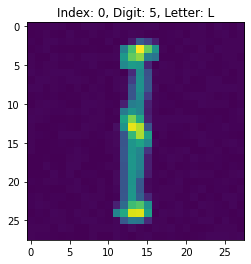

In [ ]:
show_data_image(0)

#model function


In [ ]:
# def create_cnn_model(x_train):
#     inputs=tf.keras.layers.Input(x_train.shape[1:])

#     bn=tf.keras.layers.BatchNormalization()(inputs) # 인수가 없어서 default 값만 사용하게 된다.
#     conv=tf.keras.layers.Conv2D(128, kernel_size=5, strides=1, padding='same', activation='relu', kernel_regularizer=l2() )(bn) # 첫 인자 16으로 줄여보기
#     bn=tf.keras.layers.BatchNormalization()(conv)
#     conv=tf.keras.layers.Conv2D(128, kernel_size=2, strides=1, padding='same', activation='relu', kernel_regularizer=l2() )(bn) # 첫 인자 16으로 줄여보기
#     pool=tf.keras.layers.MaxPooling2D((2, 2))(conv)

#     bn=tf.keras.layers.BatchNormalization()(pool)
#     conv=tf.keras.layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu', kernel_regularizer=l2() )(bn)
#     bn=tf.keras.layers.BatchNormalization()(conv)
#     conv=tf.keras.layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu', kernel_regularizer=l2() )(bn)
#     pool=tf.keras.layers.MaxPooling2D((2, 2))(conv)

#     flatten=tf.keras.layers.Flatten()(pool)

#     bn=tf.keras.layers.BatchNormalization()(flatten)
#     dense=tf.keras.layers.Dense(200, activation='relu')(bn)

#     bn=tf.keras.layers.BatchNormalization()(dense)
#     outputs=tf.keras.layers.Dense(10, activation='softmax')(bn)

#     model=tf.keras.models.Model(inputs=inputs, outputs=outputs)

#     return model


In [ ]:
def create_cnn_model(train_x):
  model = Sequential()

  model.add(Conv2D(16,(3,3),activation='relu',input_shape=(28,28,1),padding='same'))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))
    
  model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(32,(5,5),activation='relu',padding='same')) 
  model.add(BatchNormalization())
  model.add(Conv2D(32,(5,5),activation='relu',padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(32,(5,5),activation='relu',padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((3,3)))
  model.add(Dropout(0.3))
    
  model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(64,(5,5),activation='relu',padding='same')) 
  model.add(BatchNormalization())
  model.add(MaxPooling2D((3,3)))
  model.add(Dropout(0.3))
    
  model.add(Flatten())

  model.add(Dense(128,activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))
  model.add(Dense(64,activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))

  model.add(Dense(10,activation='softmax'))
  return model

In [ ]:
model = Sequential()

model.add(Conv2D(16,(3,3),activation='relu',input_shape=(28,28,1),padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
  
model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(32,(5,5),activation='relu',padding='same')) 
model.add(BatchNormalization())
model.add(Conv2D(32,(5,5),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(32,(5,5),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((3,3)))
model.add(Dropout(0.3))
  
model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64,(5,5),activation='relu',padding='same')) 
model.add(BatchNormalization())
model.add(MaxPooling2D((3,3)))
model.add(Dropout(0.3))
  
model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(10,activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

#model training

Epoch 1/100
7/7 [==============================] - 0s 30ms/step - loss: 0.0411 - accuracy: 0.9872 - val_loss: 0.3524 - val_accuracy: 0.9049
Epoch 2/100
7/7 [==============================] - 0s 23ms/step - loss: 0.0133 - accuracy: 0.9963 - val_loss: 0.3400 - val_accuracy: 0.9171
Epoch 3/100
7/7 [==============================] - 0s 23ms/step - loss: 0.0233 - accuracy: 0.9908 - val_loss: 0.3218 - val_accuracy: 0.9171
Epoch 4/100
7/7 [==============================] - 0s 23ms/step - loss: 0.0264 - accuracy: 0.9933 - val_loss: 0.4152 - val_accuracy: 0.9146
Epoch 5/100
7/7 [==============================] - 0s 24ms/step - loss: 0.0194 - accuracy: 0.9933 - val_loss: 0.4283 - val_accuracy: 0.9171
Epoch 6/100
7/7 [==============================] - 0s 24ms/step - loss: 0.0137 - accuracy: 0.9945 - val_loss: 0.4018 - val_accuracy: 0.9122
Epoch 7/100
7/7 [==============================] - 0s 25ms/step - loss: 0.0190 - accuracy: 0.9933 - val_loss: 0.4105 - val_accuracy: 0.9073
Epoch 8/100
7/7 [===

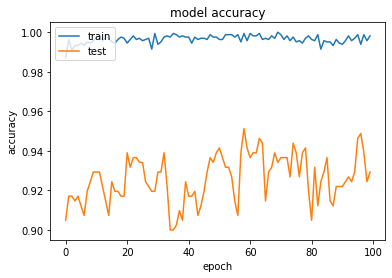

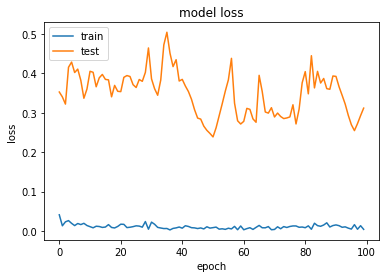

In [ ]:
model_path='model/'

if not os.path.exists(model_path):
  os.mkdir(model_path)

# callback 정의(ModelCheckpoint, EarlyStopping)

# ModelCheckpoint: 학습 중 모델 저장
checkpoint=tf.keras.callbacks.ModelCheckpoint(
    filepath=model_path+'Epoch_{epoch:03d}_Val_{val_accuracy:.3f}.hdf5', # 모델 파일명 정의
    monitor='val_accuracy', # val_accuracy(validation accuracy) 값 모니터링
    save_best_only=True # val_accuracy(validation accuracy) 값이 높은 것만 저장해주는 기능
)

# EarlyStopping: 학습 중 점수가 Validation 하락하면 학습 종료
early_stopping=tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', # val_accuracy(validation accuracy) 값을 보고 stop
    min_delta=0.1, # 판단 기준(얼마나 높아야 높아졌다고 판단할 것인가?)
    patience=10, # 점수가 한 번 떨어졌다고 바로 멈추면 좋은 (점수를 받는) 모델을 얻기 힘들다. 점수가 몇 번 떨어져도 봐줄건지 정한다.
    mode='max' # max면 높을수록 좋다고 평가한다. min면 낮을수록 좋다고 평가한다.
)

# history = model.fit(
#     train_x, train_y,
#     epochs=100, batch_size=16, verbose=1
#     # validation_split=0.2, shuffle=True, # validation dataset 나누기
#     # callbacks=[checkpoint]
# )
history = model.fit(train_x, train_y, epochs=100, validation_split=0.2, verbose=1, batch_size=128*2)

model.predict(test_x)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()